In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch

In [4]:
PATH = "data/galaxy-zoo-2/"

## Take a look

In [5]:
os.listdir(PATH)

['all_ones_benchmark.csv',
 'all_zeros_benchmark.csv',
 'central_pixel_benchmark.csv',
 'galSpecExtra-dr8.fits',
 'images_test_rev1',
 'images_training_rev1',
 'models',
 'tmp',
 'training_solutions_rev1.csv',
 'zoo2MainSpecz.csv',
 'zoo2MainSpecz.csv.gz']

In [6]:
label_csv = f'{PATH}training_solutions_rev1.csv'

# number of rows (first one is comment)
n = len(list(open(label_csv))) - 1 

# get random crossvalidation labels
val_idxs = get_cv_idxs(n)

In [7]:
print(n); print(len(val_idxs))

61578
12315


read labeled data

In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


Here is what the classes mean:

![Decision tree classes](https://kaggle2.blob.core.windows.net/competitions/kaggle/3175/media/Screen%20Shot%202013-09-25%20at%2010.15.06.png)

## Defining the problem
We see that there are 37 classes here, with each representing some answer in the decision tree. I'm more interested in doing a multiple category, single question classification problem (because it's easier). One way to do this is to crossmatch answers between the Kaggle challenge catalog and with the SDSS object IDs through the [GalaxyZoo website](https://data.galaxyzoo.org/), and then querying the SDSS SkyServer for better data (e.g., `GalSpecLine`) using those results.

## New data products:

    zoo2MainSpecz.csv         These are basically the same labels as before, 
                              except that we have the Sloan IDs
    galSpecExtra-dr8.fits     The SDSS DR8 extra spectroscopically determined 
                              properties, including BPT classification, 
                              metallicity, sSFR, etc. From MPA/JHU.
                              
In order to get these all together, I'll need to match the Kaggle IDs to the SDSS `galSpecExtra` labels ([see documentation](https://data.sdss.org/datamodel/files/SPECTRO_REDUX/galSpecExtra.html)).

In [10]:
from astropy.io import fits
gse = fits.getdata(f'{PATH}galSpecExtra-dr8.fits')

In [11]:
gse.columns

ColDefs(
    name = 'SPECOBJID'; format = '19A'
    name = 'PLATEID'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'BPTCLASS'; format = 'I'
    name = 'LGM_TOT_P2P5'; format = 'E'
    name = 'LGM_TOT_P16'; format = 'E'
    name = 'LGM_TOT_P50'; format = 'E'
    name = 'LGM_TOT_P84'; format = 'E'
    name = 'LGM_TOT_P97P5'; format = 'E'
    name = 'LGM_FIB_P2P5'; format = 'E'
    name = 'LGM_FIB_P16'; format = 'E'
    name = 'LGM_FIB_P50'; format = 'E'
    name = 'LGM_FIB_P84'; format = 'E'
    name = 'LGM_FIB_P97P5'; format = 'E'
    name = 'OH_P2P5'; format = 'E'
    name = 'OH_P16'; format = 'E'
    name = 'OH_P50'; format = 'E'
    name = 'OH_P84'; format = 'E'
    name = 'OH_P97P5'; format = 'E'
    name = 'OH_ENTROPY'; format = 'E'
    name = 'SFR_TOT_P2P5'; format = 'E'
    name = 'SFR_TOT_P16'; format = 'E'
    name = 'SFR_TOT_P50'; format = 'E'
    name = 'SFR_TOT_P84'; format = 'E'
    name = 'SFR_TOT_P97P5'; format = 'E'
    name =

In [12]:
bpt = pd.DataFrame(np.column_stack((gse['SPECOBJID'], gse['BPTCLASS'])), columns=['SpecObjID', 'BPTClass'])
bpt.set_index('SpecObjID',)
bpt.head()

,SpecObjID,BPTClass
0,299489676975171584,3
1,299489951853078528,-1
2,299490226730985472,-1
3,299490501608892416,-1
4,299490776486799360,-1


In [13]:
bpt.BPTClass.value_counts()

-1    870214
0     370619
2     230513
1     215224
5      77586
3      52006
4      27038
Name: BPTClass, dtype: int64

## Find the intersection of BPT and Kaggle and GZ2

In [14]:
gz2 = pd.read_csv(f'{PATH}zoo2MainSpecz.csv')
gz2.head()

,specobjid,dr8objid,dr7objid,ra,dec,rastring,decstring,sample,gz2class,total_classifications,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,1.802675e+18,NaN,588017703996096547,160.99040,11.703790,10:43:57.70,+11:42:13.6,original,SBb?t,44,...,0.225,0.225,0.225,0,10,10.0,0.250,0.250,0.250,0
1,1.992984e+18,NaN,587738569780428805,192.41083,15.164207,12:49:38.60,+15:09:51.1,original,Ser,45,...,0.000,0.000,0.000,0,0,0.0,0.000,0.000,0.000,0
2,1.489569e+18,NaN,587735695913320507,210.80220,54.348953,14:03:12.53,+54:20:56.2,original,Sc+t,46,...,0.651,0.651,0.651,0,3,3.0,0.070,0.070,0.070,0
3,2.924084e+18,1.237668e+18,587742775634624545,185.30342,18.382704,12:21:12.82,+18:22:57.7,original,SBc(r),45,...,0.071,0.071,0.071,0,6,6.0,0.429,0.429,0.429,0
4,1.387165e+18,1.237658e+18,587732769983889439,187.36679,8.749928,12:29:28.03,+08:44:59.7,extra,Ser,49,...,0.000,0.000,0.000,0,1,1.0,1.000,1.000,1.000,0


In [15]:
label_df.columns

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')

In [16]:
for c in gz2.columns:
    print(c)

specobjid
dr8objid
dr7objid
ra
dec
rastring
decstring
sample
gz2class
total_classifications
total_votes
t01_smooth_or_features_a01_smooth_count
t01_smooth_or_features_a01_smooth_weight
t01_smooth_or_features_a01_smooth_fraction
t01_smooth_or_features_a01_smooth_weighted_fraction
t01_smooth_or_features_a01_smooth_debiased
t01_smooth_or_features_a01_smooth_flag
t01_smooth_or_features_a02_features_or_disk_count
t01_smooth_or_features_a02_features_or_disk_weight
t01_smooth_or_features_a02_features_or_disk_fraction
t01_smooth_or_features_a02_features_or_disk_weighted_fraction
t01_smooth_or_features_a02_features_or_disk_debiased
t01_smooth_or_features_a02_features_or_disk_flag
t01_smooth_or_features_a03_star_or_artifact_count
t01_smooth_or_features_a03_star_or_artifact_weight
t01_smooth_or_features_a03_star_or_artifact_fraction
t01_smooth_or_features_a03_star_or_artifact_weighted_fraction
t01_smooth_or_features_a03_star_or_artifact_debiased
t01_smooth_or_features_a03_star_or_artifact_flag
t0

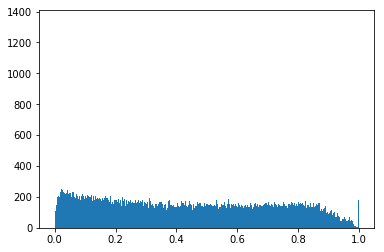

In [17]:
plt.hist(label_df['Class1.1'], bins=400);

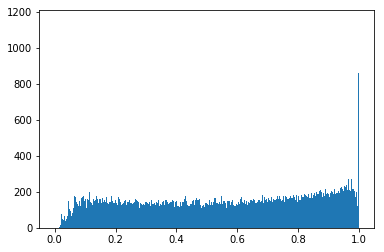

In [18]:
plt.hist(label_df['Class1.2'], bins=400);

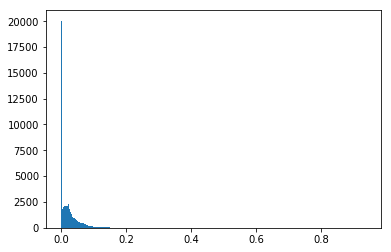

In [19]:
plt.hist(label_df['Class1.3'], bins=400);

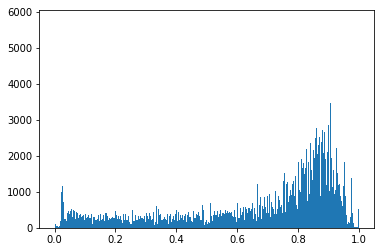

In [20]:
plt.hist(gz2['t01_smooth_or_features_a01_smooth_weighted_fraction'], bins=400);

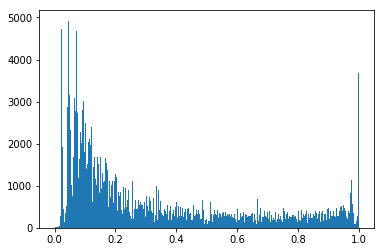

In [21]:
plt.hist(gz2['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'], bins=400);

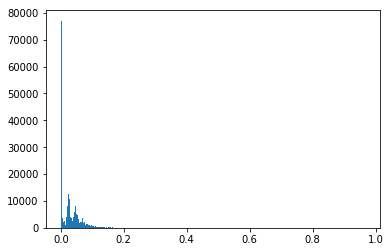

In [22]:
plt.hist(gz2['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'], bins=400);

From this I believe that the Kaggle data set comprises the *weighted* fractions of answers. Otherwise we would expect to see peaks corresponding to multiples of 40, 41, 42, (the number of volunteers who answered yes or no), etc.

In [23]:
# question 1 (weighted)
gz2_q1 = gz2[['specobjid', 't01_smooth_or_features_a01_smooth_weighted_fraction', 't01_smooth_or_features_a02_features_or_disk_weighted_fraction', 't01_smooth_or_features_a03_star_or_artifact_weighted_fraction']]
#gz2_q1.set_index('specobjid', inplace=True)
gz2_q1.columns = ['SpecObjID', 'Class1.1', 'Class1.2', 'Class1.3']
gz2_q1.describe()

,SpecObjID,Class1.1,Class1.2,Class1.3
count,2.434860e+05,243500.000000,243500.000000,243500.000000
mean,1.705785e+18,0.644157,0.324783,0.031055
std,8.225568e+17,0.288679,0.296113,0.041355
min,-9.999000e+03,0.000000,0.000000,0.000000
25%,1.019059e+18,0.455000,0.092000,0.000000
50%,1.781203e+18,0.767000,0.194000,0.024000
75%,2.382500e+18,0.871000,0.515000,0.046000
max,3.383502e+18,1.000000,1.000000,0.967000


In [24]:
from astroML.crossmatch import crossmatch

In [25]:
# inds of gz2_q1 in label_df
_, inds = crossmatch(label_df[['Class1.1', 'Class1.2', 'Class1.3']].as_matrix(), 
                     gz2_q1[['Class1.1', 'Class1.2', 'Class1.3']].as_matrix(),
                     max_distance=1e-2)

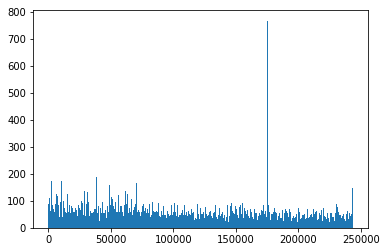

In [26]:
plt.hist(inds, bins=1000);

In [27]:
len(label_df), len(gz2_q1)

(61578, 243500)

In [28]:
# what's going on here?
unique_inds, inds_of_inds, counts = np.unique(inds, return_index=True, return_counts=True)
max_ind = unique_inds[np.argmax(counts)]
gz2_q1.iloc[max_ind]

SpecObjID    9.796786e+17
Class1.1     0.000000e+00
Class1.2     1.000000e+00
Class1.3     0.000000e+00
Name: 175539, dtype: float64

Ahh, makes sense. Some things are 100% classified as spiral or 100% classified as spheroidal, so they can't be distinguished from the others. Let's try throwing away all non-unique indices and see how many are left.

In [29]:
unique_inds[counts == 1].shape

(14504,)

In [30]:
# unique indices of
unique_gz2 = gz2_q1.iloc[unique_inds[counts == 1]]
unique_gz2.head()

,SpecObjID,Class1.1,Class1.2,Class1.3
7,1.625961e+18,0.091,0.871,0.038
11,5.888704e+17,0.071,0.873,0.056
23,1.631477e+18,0.067,0.918,0.014
51,1.818456e+18,0.380,0.598,0.023
68,5.889144e+17,0.301,0.696,0.003


In [31]:
# indices of the unique crossmatched indices (i.e., where label_df X gz2 is unique)
unique_kaggle = label_df.iloc[inds_of_inds[counts == 1]]
unique_kaggle.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
3448,151758,0.091882,0.869566,0.038552,0.000000,0.869566,0.047983,0.821583,0.050693,0.818873,...,0.000000,0.009495,0.041198,0.000000,0.000000,0.000000,0.000000,0.000000,0.021545,0.029149
1954,129195,0.069904,0.873496,0.056601,0.032767,0.840729,0.656358,0.184371,0.406235,0.434495,...,0.000000,0.153209,0.094545,0.158480,0.017944,0.068722,0.076622,0.081414,0.000000,0.161533
52636,866833,0.067146,0.919020,0.013833,0.023996,0.895024,0.412323,0.482702,0.640864,0.254160,...,0.000000,0.070494,0.136311,0.434059,0.000000,0.501635,0.051127,0.000000,0.059267,0.028835
1236,118644,0.379620,0.597403,0.022977,0.413403,0.184000,0.115000,0.069000,0.115000,0.069000,...,0.137663,0.000000,0.023000,0.092000,0.000000,0.115000,0.000000,0.000000,0.000000,0.000000
60274,981080,0.300151,0.695930,0.003919,0.118545,0.577385,0.050820,0.526564,0.355654,0.221731,...,0.079963,0.316032,0.039622,0.000000,0.000000,0.081253,0.000000,0.000000,0.000000,0.274401


#### Note: these might still be mismatched galaxies, which would then make their properties (such as BPT classification) incorrect. Oh well, let's give it a go.

In [32]:
unique_kaggle.shape, unique_gz2.shape

((14504, 38), (14504, 4))

In [33]:
unique = pd.DataFrame({'GalaxyID': unique_kaggle.GalaxyID.as_matrix(),
                       'SpecObjID': unique_gz2.SpecObjID.as_matrix()})
unique.head()

,GalaxyID,SpecObjID
0,151758,1.625961e+18
1,129195,5.888704e+17
2,866833,1.631477e+18
3,118644,1.818456e+18
4,981080,5.889144e+17


In [34]:
unique.dtypes

GalaxyID       int64
SpecObjID    float64
dtype: object

The reason that the SpecObjID dtype is `float` is because there were NaN values in there apparently. Let's just `int` cast them now.

In [35]:
unique.dropna(inplace=True)
unique.SpecObjID = pd.to_numeric(unique.SpecObjID, downcast='integer')
unique.head()

,GalaxyID,SpecObjID
0,151758,1625960870049769472
1,129195,588870424280983552
2,866833,1631476571170695168
3,118644,1818456220894259200
4,981080,588914404746094592


In [36]:
for col in ['SpecObjID', 'BPTClass']:
    bpt[col] = pd.to_numeric(bpt[col], errors='coerce')

bpt.dropna(inplace=True)

for col in ['SpecObjID', 'BPTClass']:
    bpt[col] = pd.to_numeric(bpt[col], downcast='integer')

bpt.head()

,SpecObjID,BPTClass
0,299489676975171584,3
1,299489951853078464,-1
2,299490226730985472,-1
3,299490501608892416,-1
4,299490776486799360,-1


In [67]:
df = pd.merge(unique, bpt, how='inner')
df.set_index('GalaxyID', inplace=True)
df.head()

,SpecObjID,BPTClass
GalaxyID,,
129195,588870424280983552,3
866833,1631476571170695168,1
118644,1818456220894259200,2
981080,588914404746094592,3
804743,1907332774558197760,-1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002012274FB70>]], dtype=object)

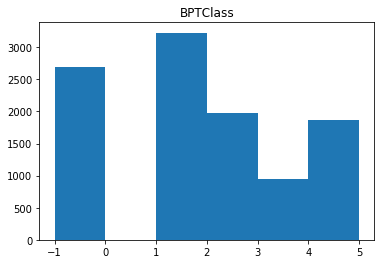

In [68]:
df.hist(column='BPTClass', bins=6, grid=False)

In [69]:
df = df[df.BPTClass > 0]
df.describe()

,SpecObjID,BPTClass
count,8.015000e+03,8015.000000
mean,1.681231e+18,2.342732
std,8.362216e+17,1.464049
min,2.995086e+17,1.000000
25%,9.874787e+17,1.000000
50%,1.613572e+18,2.000000
75%,2.405531e+18,3.000000
max,3.348581e+18,5.000000


In [126]:
bpt_dict = {
    1: 'star-forming',
    2: 'low-star-forming',
    3: 'composite',
    4: 'AGN',
    5: 'LINER'
}

df.BPTClass = df.BPTClass.map(bpt_dict)
df.head()

,SpecObjID,BPTClass
GalaxyID,,
129195,588870424280983552,composite
866833,1631476571170695168,star-forming
118644,1818456220894259200,low-star-forming
981080,588914404746094592,composite
662778,2353280671859894272,star-forming


In [82]:
df[['BPTClass']].to_csv(f'{PATH}bpt_class.csv', index=True)

In [73]:
# save the BPT classified training set images
for galaxy_id in df.index:
    if os.path.exists(f'{PATH}images_training_rev1/{galaxy_id}.jpg'):
        shutil.copy(f'{PATH}images_training_rev1/{galaxy_id}.jpg', 
                    f'{PATH}bpt_training/{galaxy_id}.jpg')
    else:
        print(f'{galaxy_id}.jpg does not exist')

## Making our own test set
Obviously taking a simple cut in galaxy ID isn't the greatest idea, but the two samples look representative enough.

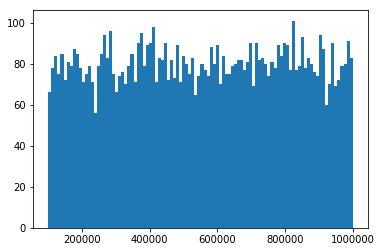

In [74]:
plt.hist(df.index, bins=100);

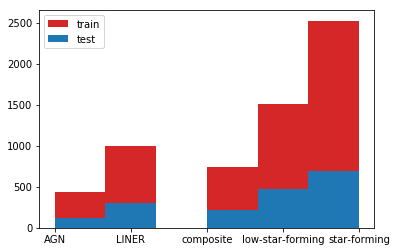

In [76]:
plt.hist(df[df.index < 800000].BPTClass, bins=6, color='C3', label='train')
plt.hist(df[df.index > 800000].BPTClass, bins=6, color='C0', label='test')
plt.legend()

In [84]:
# above this number, use data for testing
test_number_cutoff = 800000

for galaxy_id in df.index:
    if os.path.exists(f'{PATH}bpt_training/{galaxy_id}.jpg') and galaxy_id > test_number_cutoff:
        shutil.move(f'{PATH}bpt_training/{galaxy_id}.jpg', 
                    f'{PATH}bpt_testing/{galaxy_id}.jpg')

        
where_train = df.index < test_number_cutoff
# save two more csv files
df[['BPTClass']][where_train].to_csv(f'{PATH}bpt_training.csv', index=True)
df[['BPTClass']][~where_train].to_csv(f'{PATH}bpt_testing.csv', index=True)

# Load data into fastai

In [85]:
# load in data with transforms
arch = resnet34
sz = 96
bs = 12
n = len(list(open(f'{PATH}bpt_training.csv'))) - 1
print(f'{n} training and crossval examples')
val_idxs = get_cv_idxs(n)

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'bpt_training', f'{PATH}bpt_training.csv', 
                                    test_name='bpt_testing', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)


6214 training and crossval examples


In [86]:
data.classes

['AGN', 'LINER', 'composite', 'low-star-forming', 'star-forming']

## Example galaxy

In [87]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/galaxy-zoo-2/bpt_training\\100053.jpg'

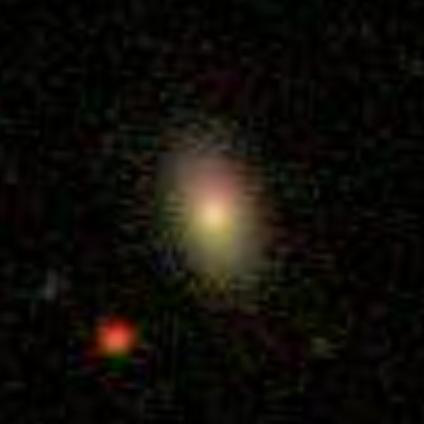

In [88]:
img = PIL.Image.open(fn); img


In [89]:
df['BPTClass'].iloc[0]

'composite'

In [90]:
img.size

(424, 424)

## An initial model

In [56]:
# first use the correct data labels


In [91]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
    data = ImageClassifierData.from_csv(PATH, 'bpt_training', f'{PATH}bpt_training.csv', 
                                        test_name='bpt_testing', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

    return data if sz > 200 else data.resize(224, 'tmp')

In [92]:
# precompute
data = get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [93]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 151/151 [00:32<00:00,  4.59it/s]


I expect to unfreeze and re-train all the layers simply because the abstractions for identifying galaxies will be different than for identifying cats or whatever. Perhaps I'll change the learning rate by 1/3 and 1/9 in the earlier and earliest layers respectively.

In [96]:
learn.save(f'{sz}_init')

## Choosing a learning rate

In [94]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|███████   | 291/415 [00:02<00:00, 143.68it/s, loss=8.41]


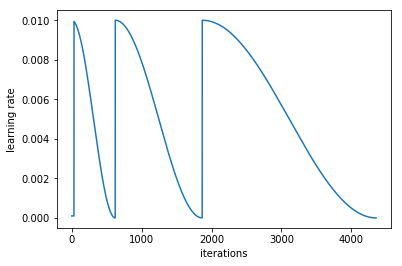

In [111]:
learn.sched.plot()

$10^{-2}$ again...

# Training starting from smaller images

### Set `precompute=False` to retrain earlier layers

In [97]:
learn = ConvLearner.pretrained(arch, get_data(96, bs), precompute=False, ps=0.5)
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.667138   1.462438   0.41868   
    1      1.613505   1.4535     0.42029                    
    2      1.586359   1.439941   0.4219                     
    3      1.582344   1.44899    0.427536                   
    4      1.527991   1.430015   0.431562                   



[array([1.43002]), 0.43156199524368066]

In [98]:
learn.save('96_pretrained')

In [99]:
learn.set_data(get_data(131, 8))
learn.fit(1e-2,3,cycle_len=1)
learn.fit(1e-2,3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.551936   1.42722    0.430757  
    1      1.553749   1.435826   0.432367                   
    2      1.502598   1.426199   0.429147                   



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.483982   1.417521   0.430757  
    1      1.46741    1.41964    0.431562                   
    2      1.466388   1.415654   0.432367                   
    3      1.445329   1.428132   0.433172                   
    4      1.447972   1.413995   0.433172                   
    5      1.455946   1.413357   0.433172                   
    6      1.440262   1.414641   0.433172                   



[array([1.41464]), 0.4331723027375201]

In [100]:
learn.save('96-131_all')

## Scoring 
Note that we're using test-time augmentation

In [129]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)

In [103]:
accuracy_np(probs, y)

0.4331723027375201

4


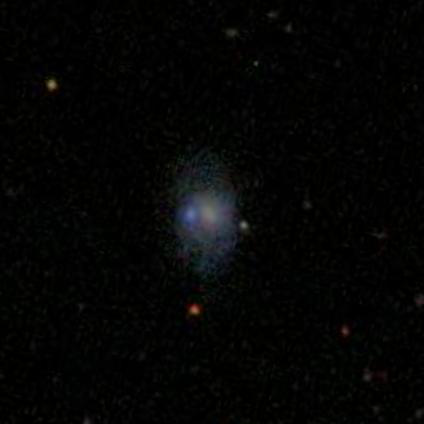

In [125]:
fname = PATH + learn.data.val_ds.fnames[0]
print(learn.data.val_y[0])
img = PIL.Image.open(fname); img

### Confusion matrix

In [104]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [105]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

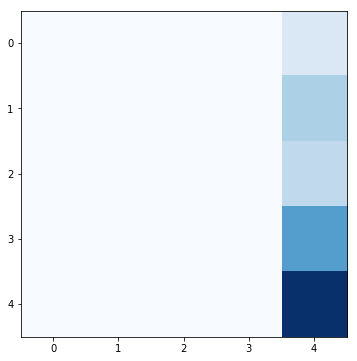

In [112]:
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')

Well there's our problem. Why is it only predicting class 4?

# Debugging time
I'm going to have it train on only a ~~single class~~ two classes, each with a few hundred examples.

In [155]:
bs = 8
sz = 96
arch = resnet34

n_examples = len(list(open(f'{PATH}bpt_debug.csv'))) - 1
val_idxs = get_cv_idxs(n_examples)

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_csv(PATH, 'bpt_training', f'{PATH}bpt_debug.csv', 
                                    test_name='bpt_testing', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, 
                                    bs=bs, num_workers=4)

In [156]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [157]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.639796   1.332792   0.501441  
    1      1.533167   1.136712   0.504323                   



[array([1.13671]), 0.5043227667423765]

In [166]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)

preds = np.argmax(probs, axis=1)
print(preds)

[0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1
 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1
 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0
 0 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0
 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1]


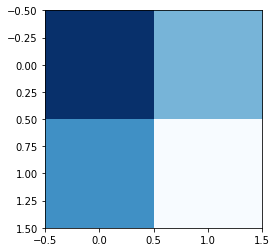

In [169]:
cm = confusion_matrix(y, preds)
plt.imshow(cm, cmap='Blues')

0


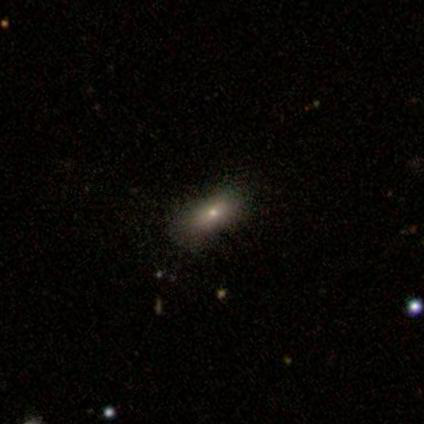

In [154]:
fname = PATH + learn.data.val_ds.fnames[12]
print(learn.data.val_y[12])
img = PIL.Image.open(fname); img

### What is going on? It's never getting class 1 (in this case, LINERs) correct

In [170]:
# needs more training?
learn.fit(1e-2,3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.936693   0.746728   0.585014  
    1      1.003878   0.758808   0.512968                    
    2      0.820003   0.712136   0.564841                    
    3      0.937985   0.819309   0.510086                    
    4      0.837506   0.763586   0.541787                    
    5      0.754824   0.695321   0.544669                    
    6      0.725318   0.700372   0.564841                    



[array([0.70037]), 0.5648414986449635]

#### Loss is decreasing, but the accuracy isn't really getting any better.

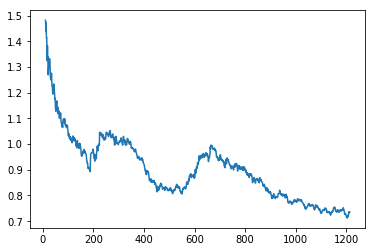

In [171]:
learn.sched.plot_loss()

In [176]:
# look for learning rate?
lrf = learn.lr_find(start_lr=1e-10)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 153/174 [00:05<00:00, 27.86it/s, loss=3.74] 


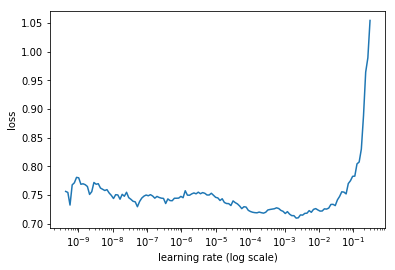

In [177]:
learn.sched.plot()

Oh wait what? Maybe the learning rate needs to be way lower?

In [178]:
lrf = learn.lr_find(start_lr=1e-15, end_lr=1e-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.769531   0.84749    0.478386  



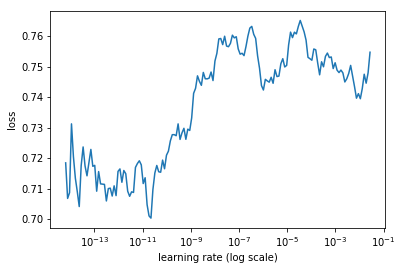

In [179]:
learn.sched.plot()

### Ah it turns out that with small batch sizes, we sometimes come across [local minima ](http://forums.fast.ai/t/what-should-my-learning-rate-be/8195/13?u=jwuphysics) in the learning rate finder

In [183]:
bs = 32
sz = 96
arch = resnet34

n_examples = len(list(open(f'{PATH}bpt_debug.csv'))) - 1
val_idxs = get_cv_idxs(n_examples)

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_csv(PATH, 'bpt_training', f'{PATH}bpt_debug.csv', 
                                    test_name='bpt_testing', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, 
                                    bs=bs, num_workers=4)

In [184]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf = learn.lr_find(start_lr=1e-6, end_lr=10)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▊ | 39/44 [00:04<00:00,  8.25it/s, loss=4.09] 


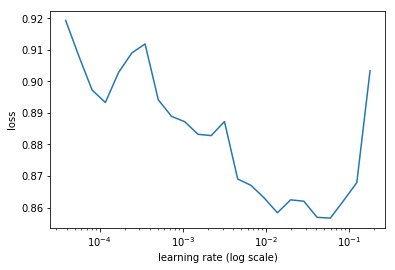

In [185]:
learn.sched.plot()

That's strangely jagged, but let's try training this using 1e-3.

In [186]:
learn.fit(1e-3, 3)
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.889826   0.709218   0.51585   
    1      0.843921   0.69872    0.567723                  
    2      0.800352   0.679665   0.56196                   



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.77623    0.676224   0.559078  
    1      0.778159   0.686375   0.570605                  
    2      0.750219   0.685578   0.570605                  
    3      0.742813   0.672955   0.564841                  
    4      0.739721   0.680544   0.564842                  
    5      0.724415   0.679737   0.576369                  
    6      0.714885   0.679193   0.590778                  



[array([0.67919]), 0.5907781000439647]

### Perhaps I need to retrain (unfreeze) the earlier layers? After all, resnet did not look for galaxies...

In [193]:
# train earlier layers??
learn.unfreeze()
lr = np.array([1/9, 1/3, 1]) * 1e-3
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.753272   0.692317   0.564842  
    1      0.757481   0.68332    0.559078                  
    2      0.74205    0.684715   0.570605                  
    3      0.72143    0.674517   0.567723                  
    4      0.718576   0.668939   0.59366                   
    5      0.711248   0.66832    0.582133                  
    6      0.708153   0.66692    0.587896                  



[array([0.66692]), 0.5878962556635612]

In [194]:
# lower the learning rate?
lr=np.array([1/9, 1/3, 1]) * 1e-4
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.718287   0.668215   0.59366   
    1      0.711248   0.667389   0.587896                  
    2      0.711384   0.664873   0.608069                  
    3      0.709535   0.666338   0.602305                  
    4      0.710138   0.668374   0.587896                  
    5      0.712312   0.669566   0.587896                  
    6      0.698455   0.670193   0.587896                  



[array([0.67019]), 0.5878962556635612]

#### Well, we've made it to ~60% accuracy. But that's pretty weak for a binary classifier...

In [195]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.703672   0.670211   0.582133  
    1      0.692852   0.667108   0.59366                   
    2      0.703774   0.668574   0.585014                  
    3      0.700613   0.667748   0.590778                  
    4      0.691068   0.667738   0.602305                  
    5      0.701178   0.668806   0.605187                  
    6      0.704188   0.667133   0.599424                  
    7      0.700912   0.669356   0.570605                  
    8      0.705432   0.667455   0.582133                  
    9      0.710613   0.668671   0.587896                  
    10     0.703307   0.667983   0.587896                  
    11     0.695797   0.667063   0.596542                  
    12     0.696828   0.665065   0.596542                  
    13     0.700427   0.668136   0.599424                  
    14     0.696648   0.667621   0.585014                  



[array([0.66762]), 0.5850144112831578]

### Am I hitting the overfitting floor? Perhaps I need to make sure that we have enough dropout layers in addition to batch normalization.. but I don't know how to do this.

In [199]:
# try another architecture
bs = 32
sz = 96
arch = vgg16

n_examples = len(list(open(f'{PATH}bpt_debug.csv'))) - 1
val_idxs = get_cv_idxs(n_examples)

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_csv(PATH, 'bpt_training', f'{PATH}bpt_debug.csv', 
                                    test_name='bpt_testing', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, 
                                    bs=bs, num_workers=8)

In [202]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf = learn.lr_find(start_lr=1e-9, end_lr=10)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 98%|█████████▊| 43/44 [00:07<00:00,  5.83it/s, loss=18]   


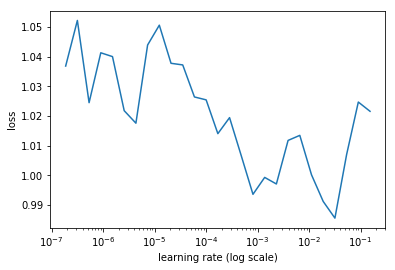

In [203]:
learn.sched.plot()

In [204]:
learn.fit(1e-4, 3)
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      1.002189   0.727968   0.521614  
    1      0.976511   0.785645   0.536023                  
    2      0.95278    0.775489   0.556196                  



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.951029   0.774995   0.54755   
    1      0.929471   0.765068   0.56196                   
    2      0.91328    0.764932   0.564841                  
    3      0.910374   0.762349   0.573487                  
    4      0.900871   0.752547   0.582133                  
    5      0.919915   0.736746   0.579251                  
    6      0.894956   0.762227   0.541787                  



[array([0.76223]), 0.5417867443747068]

Meh. Not sure how to fix this...